# Interferometric oblate star model:

In this notebook, I will demonstrate how to go from the ELR model, which takes only two parameters, a rotation rate $\omega$ and the polar angle on the star $\theta$ to a 3d model of a star, then how to project that model into 2D and create a synthetic star image ready for extracting interferometric observables. All this must be done in jax to maintain differentiability!

In [1]:
import sys
sys.path.append("..")

#import the jaxified ELR model
from core import ELR

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt

#packages to plot the star using realistic blackbody colors
from colorsys import rgb_to_hls, hls_to_rgb, rgb_to_hsv, hsv_to_rgb
from colorpy import colormodels
from colorpy import blackbody

#Flatiron institute nonuniform fast fourier transform
#will be used to FT the data for interferometric observables
#from jax_finufft import nufft1
from scipy.spatial import ConvexHull

## 3d model of the star:

We start by evaluating the radius, temperature and flux at various polar angles on the star as we did in the previous notebook (jax_elr_model_oblate_star.ipynb). Then, I rotate the model about the y (vertical) axis to obtain a 3d representation of the star.

In [2]:
omega = 0.9
latent = jnp.linspace(-1,1,30)
thetas = jnp.linspace(0,jnp.pi,30) #jnp.arccos(latent)
phi = jnp.linspace(0.0, 2*jnp.pi,30)
rtws, Ts, Fs = ELR.solve_ELR_vec(omega, thetas)

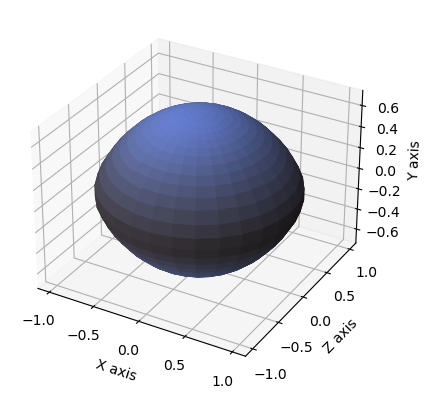

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('Y axis')

#meshgrid for the surface plot, will have to ravel later into a 1d array
U, V = np.meshgrid(thetas, phi)
Fs = (Fs/jnp.max(Fs))

#blackbody colors for the plot, assuming an average temperature of 7500K
rs, gs, bs = [], [], []
for T, F in zip(Ts, Fs):
    xyz = blackbody.blackbody_color(np.rint(T*7500))
    r,g,b = colormodels.irgb_from_xyz(xyz)
    h,s,v  = rgb_to_hsv(r/ 255.0, g / 255.0, b / 255.0)
    #print(h,s,v)
    v = max(min(v * F, 1.0), 0.0)
    #I apply an arbitrary saturation to make the colors more apparent
    s = max(min(s * 3.0, 1.0), 0.0)
    r, g, b = hsv_to_rgb(h,s,v)
    rs.append(r)
    gs.append(g)
    bs.append(b)

#make the colors the same shape as the surface
rs = np.array(rs)*np.ones_like(V)
gs = np.array(gs)*np.ones_like(V)
bs = np.array(bs)*np.ones_like(V)

#I haven't found a better way to do this;
#Given r, g and b with shape same as X, Y, Z, make into an array of shape (x, 3)
colors = np.einsum('ijk->jki',[rs, gs, bs])

#now perform the rotation--should be same as conversion from cartesian to spherical coords
X = rtws*jnp.sin(U)*jnp.cos(V)
Y = rtws*jnp.cos(U)
Z = rtws*jnp.sin(U)*jnp.sin(V)

#plot the surface along with the colors
ax.plot_surface(X, Z, Y, facecolors=colors)

plt.show()

## Triangulation with Convex Hull:

In order to go from a 3d point cloud representation of our star to a 2D differentiable model, we must approximate our star using a triangulated mesh, similar to the PHOEBE package (http://www.phoebe-project.org/). This is, to my knowledge, the first time this has been applied to interferometry and it may offer some advantages over the standard method of gridding the stellar model onto a pixel basis (creating an image) before creating interferometric observables.

Firstly, the star in the pixel basis is usually padded onto a black background which results in a hard edge at the stellar terminator. This makes differentiation difficult. While this can be avoided by softening the edge with a convolution, it adds a lot of extra steps and computational effort. By using a triangulation of the star, we extract interferometric observables, such as squared visibilities and closure phases, directly from the triangle mesh. Differentiation of this model tracks how changes in stellar parameters affect the point cloud directly. 

Secondly, pixel basis interferometry usually oversamples the model star image and then performs a Fourier transform. Again, because of edge effects, this necessitates a very large matrix on which the FT is performed, which is computationally expensive. Rather than performing the FT on a densely oversampled image, we may be able to get away with much lower resolutions using this method instead with equivalent precision in the observables.

Lastly, the triangulation itself is only applied once for a given method of constructing the point cloud and does not change with different stellar parameters.

We start with a point cloud $P$ with size Nx3. The output is an array $T$ with size Mx3, where each row contains 3 indices of points in $P$ corresponding to the vertices of one triangle, and M is the number of triangles in the Delauney triangulation.

In [5]:
#First create a uniformly sampled grid on a spherical surface
N = 31
thetas = jnp.linspace(0,jnp.pi,N)

def revolve(thetas, rtws, Ts, Fs):
    """ Take a set of angles theta spaced evenly forming an arc of a circle
        and returns a point cloud where each point has equal arc length"""
    angle = jnp.pi/(N-1)
    points = []
    for theta, rtw, T, F in zip(thetas,rtws, Ts, Fs):
        r = jnp.sin(theta)*rtw
        phi = np.arange(0,2*jnp.pi,step=angle/r)
        
        points.extend([i for i in jnp.stack([jnp.repeat(rtw,len(phi)),
                                             jnp.repeat(T,len(phi)),
                                             jnp.repeat(F,len(phi)),
                                             jnp.repeat(theta,len(phi)),
                                             phi],axis=1)])
    return points

def spherical_to_cartesian(r, theta, phi):
    x = r * jnp.sin(theta) * jnp.cos(phi)
    y = r * jnp.cos(theta)
    z = r * jnp.sin(theta) * jnp.sin(phi)
    return jnp.array([x, y, z])



In [6]:
rtws, Ts, Fs = ELR.solve_ELR_vec(omega, thetas)
Fs = (Fs/jnp.max(Fs))
rtw, Ts, Fs, theta,phi = np.array(revolve(thetas, rtws, Ts, Fs)).T
x, y, z = spherical_to_cartesian(rtw,theta,phi)

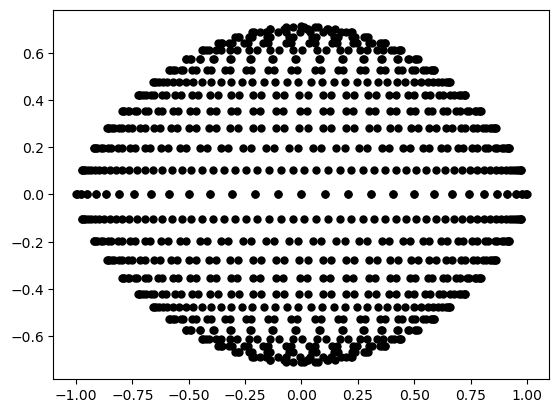

In [7]:
plt.plot(x,y,'ko',ms=5)

In [8]:
points = jnp.stack([x,y,z],axis=1)

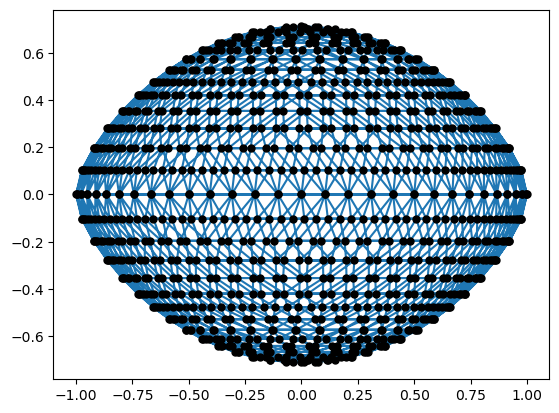

In [9]:
hull = ConvexHull(points);
plt.plot(points[:,0], points[:,1], 'ko',ms=5);
plt.triplot(points[:,0], points[:,1],triangles=hull.simplices,c='C0');

## Rotation of point cloud:

Next, I rotate the point cloud into a given viewing orientation in preparation to project into 2D. Starting with a star with its rotation axis on the y-axis (y-vertical coordinates), two rotations will yield any viewing orientation, where the viewing axis is always at infinity on the z-axis. First, I apply a rotation by an inclination angle $i$ using the rotation matrix:
$$
P' = Rx = \begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(i) & -\sin(i) \\
0 & \sin(i) & \cos(i)
\end{bmatrix} P
$$

This inclines the star's pole towards or away from the observer. Then, I rotate the star by an obliquity angle $\theta$ using the rotation matrix below:
$$
P' = Rz = \begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1
\end{bmatrix} P'
$$

Now, the rotated point cloud can be projected into 2D by simply deleting the z-axis. However, there is the additional problem of deleting the back face which should not be visible in the final model, which is the subject of the next section.

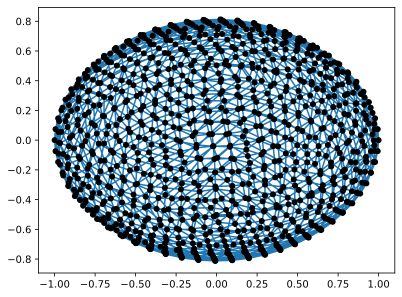

In [10]:
%config InlineBackend.figure_format = 'svg'
def rotate_point_cloud(points, inclination, obliquity):
    # define the rotation matrices
    R_x = jnp.array([[1, 0, 0],
                     [0, jnp.cos(inclination), -jnp.sin(inclination)],
                     [0, jnp.sin(inclination), jnp.cos(inclination)]])
    R_z = jnp.array([[jnp.cos(obliquity), -jnp.sin(obliquity), 0],
                     [jnp.sin(obliquity), jnp.cos(obliquity), 0],
                     [0, 0, 1]])
    # rotate the point cloud
    points_rotated = jnp.dot(points, R_x)
    points_rotated = jnp.dot(points_rotated, R_z)
    return points_rotated

# rotate the point cloud
points_rotated = rotate_point_cloud(points, -jnp.pi/4, 0)

plt.plot(points_rotated[:,0], points_rotated[:,1], 'ko',ms=5);
plt.triplot(points_rotated[:,0], points_rotated[:,1],triangles=hull.simplices,c='C0');

## Deleting the back face of the mesh:

We started with a 3D point cloud $P'$, which has been rotated into the observation frame. The point cloud represents a star whose back side should not be visible from our point of view. How do we delete the back face? The most simple solution for a sphere would be to delete points that have a negative z-axis value. However, this does not work for non-spherical objects, so we must instead use an approach that works for convex hulls: to compute the normal vectors of each triangle and delete triangles with a negative z-component to its normal vector. 

The triangle_normals function takes a point cloud $P'$ of size Nx3 and a Delaunay triangulation $T$ of the points of size Mx3 as inputs. It returns the normal vectors of each triangle in the triangulation, of size Mx3.

The function first computes the edges of the triangles by subtracting the coordinates of the vertices of the triangles. Then, it computes the normal vectors of the triangles by calculating the cross product of the edges of each triangle in jax.numpy. It then computes the dot product of the normal vector and the vector from (0,0,0) to the barycenter of the triangle--if this is negative, it means the normal vector is pointing into the convex hull and must be reversed.

I also compute the barycenter of each triangle, which will be described later, but is used here only to define the point out of which the triangle normal emanates in the plot.

In [11]:
def triangle_normals(points, triangulation):
    a = points[triangulation[:,0],:]
    b = points[triangulation[:,1],:]
    c = points[triangulation[:,2],:]
    # compute the normal vectors
    normals = jnp.cross(b-a, c-a)
    # compute the center of the triangle
    center = (a + b + c) / 3
    # reverse the normal vector if the dot product is negative
    mask = jnp.sum(normals * center, axis=1) < 0
    normals = normals.at[mask].set(-normals[mask])
    return normals

def barycenter(points, triangulation):
    # get the coordinates of the triangle vertices
    x = points[triangulation, 0]
    y = points[triangulation, 1]
    z = points[triangulation, 2]
    # compute the barycenter coordinates
    x_barycenter = jnp.mean(x, axis=1)
    y_barycenter = jnp.mean(y, axis=1)
    z_barycenter = jnp.mean(z, axis=1)
    # stack the barycenter coordinates into an array
    barycenters = jnp.stack((x_barycenter, y_barycenter, z_barycenter), axis=1)
    return barycenters

# compute the normal vectors
normals = triangle_normals(points_rotated, hull.simplices)
#compute the barycenters (for plotting)
barycenters = barycenter(points_rotated,hull.simplices)

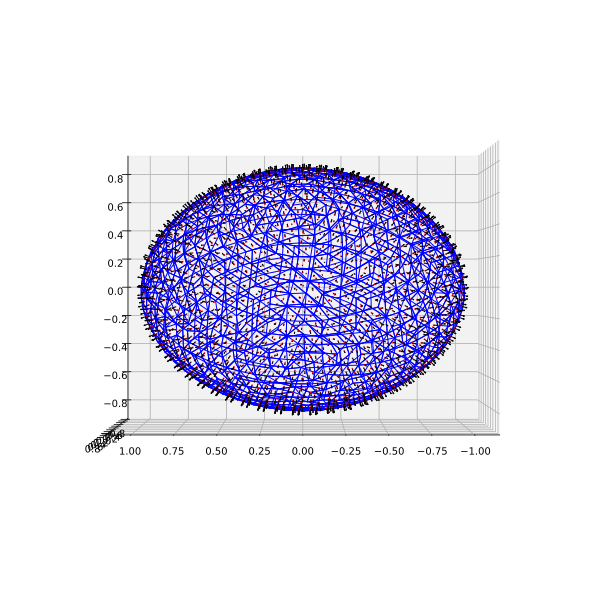

In [12]:
%config InlineBackend.figure_format = 'svg'
# create a figure and a 3D axis
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=90)
# plot the triangles
for triangle in hull.simplices:
    ax.plot(points_rotated[triangle,0], points_rotated[triangle,2], points_rotated[triangle,1], 'b-',lw=1)
# plot the barycenters
ax.scatter(barycenters[:,0], barycenters[::,2], barycenters[:,1], c='r',s=1)
# plot the normals as arrows
ax.quiver(barycenters[:,0], barycenters[:,2], barycenters[:,1],
          normals[:,0], normals[:,2], normals[:,1],
          length=3, color='k',lw=1)
# show the plot
plt.tight_layout(pad=0)
plt.show()

## Computing brightness and temperatures at the barycenter of each triangle


If we perform the Fourier transform on the point cloud as is, we will run into a problem: because the data are not evenly sampled on the face of the star, some points will contribute more to the Fourier transform than others, essentially the denser the points are, the brighter it will appear. We must normalize each point by density of points neighboring it. I do this by computing the barycenter of each triangle and finding the brightness at the barycenter by averaging the brightness at each of the vertices.

Then, I divide by the area of the triangle. This is calculated according to the following algorithm: 

$$
area = 0.5 \left| u \times v \right|
$$

where u and v are the vectors that represent the edges of the triangle.

### Barycenters:

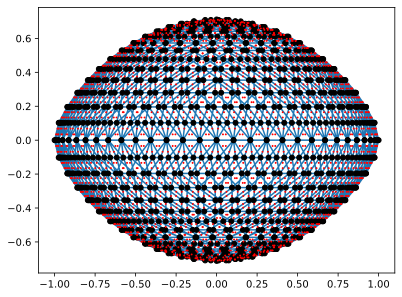

In [13]:
%config InlineBackend.figure_format = 'svg'
plt.plot(points[:,0], points[:,1], 'ko',ms=5);
plt.triplot(points[:,0], points[:,1],triangles=hull.simplices,c='C0');

#compute barycenter of nonrotated points to make the plot cleaner
barycenters_nr = barycenter(points,hull.simplices)
plt.plot(barycenters_nr[:,0], barycenters_nr[:,1], 'ro',ms=1);

# compute the barycenters
barycenters = barycenter(points_rotated, hull.simplices)

### Areas:

In [14]:
def triangle_area(points, triangulation):
    a = points[triangulation[:,0],:]
    b = points[triangulation[:,1],:]
    c = points[triangulation[:,2],:]
    # compute the edges of the triangle
    u = b - a
    v = c - a
    # compute the cross product
    w = jnp.cross(u, v)
    # compute the area using the formula
    area = 0.5 * jnp.linalg.norm(w, axis=1)
    return area

## Projection into 2D:

Now we project the 3d surface into 2d along the line of sight. To do this, we must take into account the visible surface of the star, and that there may be regions of the star that are blocked from our view. I do this by removing all triangles with a negative normal vector. Next, I simply delete the z-axis to project into 2D

In [15]:
brightness = Fs
temperature = Ts

In [16]:
# compute the brightness at the barycenters
brightness_barycenters = brightness[hull.simplices]
temperature_barycenters = brightness[hull.simplices]
brightness_barycenters = jnp.mean(brightness_barycenters, axis=1)
temperature_barycenters = jnp.mean(temperature_barycenters,axis=1)

# compute the areas of the triangles
areas = triangle_area(points_rotated, hull.simplices)
# normalize the brightness by the area
brightness_barycenters = brightness_barycenters #/ areas
temperature_barycenters = temperature_barycenters #/ areas

# select triangles with positive z component of the normal vector
mask = normals[:,2] > 0
barycenter_temperature = temperature_barycenters[mask]
barycenter_brightness = brightness_barycenters[mask]
# delete the z axis from the barycenters
barycenters_projected = jnp.delete(barycenters[mask], 2, axis=1)

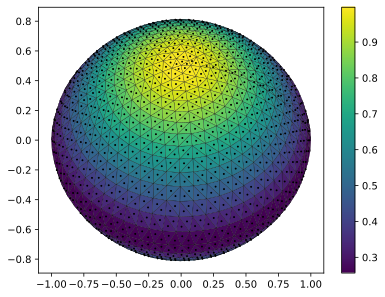

In [17]:
%config InlineBackend.figure_format = 'svg'
colors = (barycenter_brightness).astype(np.float32)
#plt.plot(points_rotated[:,0], points_rotated[:,1], 'ko',ms=5);
c = plt.tripcolor(points_rotated[:,0], points_rotated[:,1],triangles=hull.simplices[mask], facecolors=colors,edgecolors='k');
plt.colorbar(c)
plt.plot(barycenters_projected[:,0], barycenters_projected[:,1], 'ko',ms=1);